# Graph Construction

In [1]:
import torch
import numpy as np
import pickle
import json
import os
from typing import Dict, List, Tuple, Optional, Union
from torch_geometric.data import HeteroData, Data
from torch_geometric.transforms import ToUndirected
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/yunhsin/UoM/ERP/gnn-music-recommender/.venv/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance(

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("🏗️  MUSIC GNN GRAPH CONSTRUCTION")
print("=" * 60)
print("🎯 Goal: Convert preprocessed data into PyTorch Geometric graph")
print("📊 Input: Preprocessed NPZ files and mappings")
print("📈 Output: HeteroData objects ready for GNN training")
print("🔗 Graph type: Heterogeneous with 5 node types and 5 edge types")
print()

🏗️  MUSIC GNN GRAPH CONSTRUCTION
🎯 Goal: Convert preprocessed data into PyTorch Geometric graph
📊 Input: Preprocessed NPZ files and mappings
📈 Output: HeteroData objects ready for GNN training
🔗 Graph type: Heterogeneous with 5 node types and 5 edge types



In [15]:
class MusicGraphConstructor:
    """
    Constructs PyTorch Geometric graphs from preprocessed music data
    """

    def __init__(self, data_dir: str):
        self.data_dir = data_dir

        # Data containers
        self.mappings = None
        self.entity_counts = None
        self.edges = None
        self.features = None
        self.splits = None
        self.metadata = None

        # Graph objects
        self.full_graph = None
        self.train_graph = None
        self.val_graph = None
        self.test_graph = None

        print(f"📂 Initializing graph constructor with data from: {data_dir}")

    def load_preprocessed_data(self):
        """Load all preprocessed components"""
        print("📥 LOADING PREPROCESSED DATA")
        print("=" * 40)

        try:
            # Load mappings
            with open(f"{self.data_dir}/mappings.pkl", 'rb') as f:
                self.mappings = pickle.load(f)
            print(f"✅ Loaded entity mappings")

            # Load entity counts
            with open(f"{self.data_dir}/entity_counts.pkl", 'rb') as f:
                self.entity_counts = pickle.load(f)
            print(f"✅ Loaded entity counts: {sum(self.entity_counts.values()):,} total nodes")

            # Load edges
            edges_data = np.load(f"{self.data_dir}/edges.npz")
            self.edges = {key: edges_data[key] for key in edges_data.keys()}
            total_edges = sum(len(edges) for edges in self.edges.values())
            print(f"✅ Loaded edge data: {total_edges:,} total edges")

            # Load features
            features_data = np.load(f"{self.data_dir}/features.npz")
            self.features = {key: features_data[key] for key in features_data.keys()}
            print(f"✅ Loaded node features for {len(self.features)} entity types")

            # Load splits
            splits_data = np.load(f"{self.data_dir}/splits.npz", allow_pickle=True)
            self.splits = {key: splits_data[key] for key in splits_data.keys()}
            print(f"✅ Loaded train/val/test splits")

            # Load metadata
            with open(f"{self.data_dir}/metadata.json", 'r') as f:
                self.metadata = json.load(f)
            print(f"✅ Loaded metadata")

            print()
            self._print_data_summary()

        except Exception as e:
            print(f"❌ Error loading data: {e}")
            raise

    def _print_data_summary(self):
        """Print comprehensive summary of loaded data"""
        print("📊 DETAILED DATA SUMMARY")
        print("=" * 40)

        # Entity counts
        print("🎵 Node Types:")
        for entity_type, count in self.entity_counts.items():
            print(f"   • {entity_type.capitalize()}: {count:,} nodes")

        print(f"\n🔗 Edge Types:")
        for edge_type, edges in self.edges.items():
            print(f"   • {edge_type}: {len(edges):,} edges")

        print(f"\n🎨 Feature Dimensions:")
        for entity_type, features in self.features.items():
            print(f"   • {entity_type.capitalize()}: {features.shape}")

        print(f"\n✂️  Data Splits:")
        print(f"   • Training edges: {len(self.splits['train_edges']):,}")
        print(f"   • Validation edges: {len(self.splits['val_edges']):,}")
        print(f"   • Test edges: {len(self.splits['test_edges']):,}")
        print()

    def create_node_mappings(self) -> Dict[str, torch.Tensor]:
        """Create global node ID mappings for the heterogeneous graph"""
        print("🗺️  CREATING GLOBAL NODE MAPPINGS")
        print("=" * 40)

        # Create continuous node IDs across all entity types
        global_node_mapping = {}
        reverse_global_mapping = {}
        current_offset = 0

        # Use the same order as in your entity_counts
        entity_order = list(self.entity_counts.keys())

        for entity_type in entity_order:
            count = self.entity_counts[entity_type]

            # Create global node IDs
            global_ids = torch.arange(current_offset, current_offset + count)
            global_node_mapping[entity_type] = global_ids

            # Create reverse mapping for debugging
            reverse_global_mapping[entity_type] = (current_offset, current_offset + count)

            print(f"   • {entity_type.capitalize()}: {current_offset:,} → {current_offset + count - 1:,}")
            current_offset += count

        print(f"\n📈 Total global nodes: {current_offset:,}")
        print()

        self.global_node_mapping = global_node_mapping
        self.reverse_global_mapping = reverse_global_mapping

        return global_node_mapping

    def create_hetero_graph(self, edge_subset: Optional[Dict[str, np.ndarray]] = None) -> HeteroData:
        """Create a heterogeneous graph using PyTorch Geometric"""
        print("🏗️  CREATING HETEROGENEOUS GRAPH")
        print("=" * 40)

        # Use full edges if no subset provided
        if edge_subset is None:
            edge_subset = self.edges

        # Initialize heterogeneous graph
        graph = HeteroData()

        # Add node features for each entity type
        print("🎨 Adding node features...")

        # Create mapping between entity_counts keys and features keys
        feature_key_mapping = {}

        # Check for exact matches first
        for entity_type in self.entity_counts.keys():
            if entity_type in self.features:
                feature_key_mapping[entity_type] = entity_type
            else:
                # Check for singular/plural variations
                possible_keys = [
                    entity_type.rstrip('s'),  # Remove 's' if present
                    entity_type + 's',       # Add 's' if not present
                    entity_type.replace('s', ''),  # Remove all 's'
                ]

                for possible_key in possible_keys:
                    if possible_key in self.features:
                        feature_key_mapping[entity_type] = possible_key
                        break

        print(f"   📝 Feature key mapping: {feature_key_mapping}")

        # Map entity count keys to graph node type names (singular)
        entity_to_node_type = {}
        for entity_type in self.entity_counts.keys():
            # Convert plural entity names to singular for graph
            if entity_type.endswith('s'):
                node_type = entity_type.rstrip('s')
            else:
                node_type = entity_type
            entity_to_node_type[entity_type] = node_type

        for entity_type in self.entity_counts.keys():
            if entity_type in feature_key_mapping:
                feature_key = feature_key_mapping[entity_type]
                node_type = entity_to_node_type[entity_type]

                # Convert to torch tensor and add to graph
                node_features = torch.tensor(self.features[feature_key], dtype=torch.float32)
                graph[node_type].x = node_features

                print(f"   • {entity_type.capitalize()}: {node_features.shape} (key: '{feature_key}' -> node: '{node_type}')")
            else:
                node_type = entity_to_node_type[entity_type]
                print(f"   ⚠️  {entity_type.capitalize()}: No features found for node type '{node_type}'")
                print(f"      Available feature keys: {list(self.features.keys())}")

        # Add edges for each relationship type
        print(f"\n🔗 Adding edge connections...")

        # Define edge type mappings for heterogeneous graph (using singular node types)
        edge_type_mappings = {
            'playlist_track': ('playlist', 'contains', 'track'),
            'track_artist': ('track', 'performed_by', 'artist'),
            'track_album': ('track', 'belongs_to', 'album'),
            'user_playlist': ('user', 'created', 'playlist'),
            'playlist_user': ('playlist', 'created_by', 'user')
        }

        for edge_type, edges in edge_subset.items():
            if edge_type in edge_type_mappings and len(edges) > 0:
                src_type, relation, dst_type = edge_type_mappings[edge_type]

                # Convert edges to torch tensor and transpose for PyG format
                edge_index = torch.tensor(edges.T, dtype=torch.long)

                # Add to graph
                graph[src_type, relation, dst_type].edge_index = edge_index

                print(f"   • {src_type} --{relation}--> {dst_type}: {len(edges):,} edges")

        print(f"\n✅ Heterogeneous graph created successfully")
        print(f"   📊 Total node types: {len(graph.node_types)}")
        print(f"   🔗 Total edge types: {len(graph.edge_types)}")

        # Verify nodes have features
        print(f"\n🔍 Node feature verification:")
        for node_type in graph.node_types:
            if hasattr(graph[node_type], 'x') and graph[node_type].x is not None:
                print(f"   ✅ {node_type}: {graph[node_type].x.shape}")
            else:
                print(f"   ❌ {node_type}: Missing features")

        return graph

    def create_train_val_test_graphs(self):
        """Create separate graphs for training, validation, and testing"""
        print("✂️  CREATING TRAIN/VALIDATION/TEST GRAPHS")
        print("=" * 50)

        # Create edge subsets for each split
        train_edges = {
            'playlist_track': self.splits['train_edges'],
            'track_artist': self.edges['track_artist'],  # Keep all structural edges
            'track_album': self.edges['track_album'],
            'user_playlist': self.edges['user_playlist'],
            'playlist_user': self.edges['playlist_user']
        }

        val_edges = {
            'playlist_track': self.splits['val_edges'],
            'track_artist': self.edges['track_artist'],
            'track_album': self.edges['track_album'],
            'user_playlist': self.edges['user_playlist'],
            'playlist_user': self.edges['playlist_user']
        }

        test_edges = {
            'playlist_track': self.splits['test_edges'],
            'track_artist': self.edges['track_artist'],
            'track_album': self.edges['track_album'],
            'user_playlist': self.edges['user_playlist'],
            'playlist_user': self.edges['playlist_user']
        }

        # Create graphs
        print("🚂 Creating training graph...")
        self.train_graph = self.create_hetero_graph(train_edges)

        print("\n🔍 Creating validation graph...")
        self.val_graph = self.create_hetero_graph(val_edges)

        print("\n🧪 Creating test graph...")
        self.test_graph = self.create_hetero_graph(test_edges)

        print(f"\n📊 GRAPH SPLIT SUMMARY:")
        print(f"   🚂 Training playlist-track edges: {len(train_edges['playlist_track']):,}")
        print(f"   🔍 Validation playlist-track edges: {len(val_edges['playlist_track']):,}")
        print(f"   🧪 Test playlist-track edges: {len(test_edges['playlist_track']):,}")
        print()

    def create_full_graph(self):
        """Create the complete graph with all edges"""
        print("🌐 CREATING COMPLETE GRAPH")
        print("=" * 40)

        self.full_graph = self.create_hetero_graph()
        print()

    def analyze_graph_structure(self):
        """Analyze and visualize graph properties"""
        print("🔍 GRAPH STRUCTURE ANALYSIS")
        print("=" * 40)

        if self.full_graph is None:
            print("❌ No graph created yet. Run create_full_graph() first.")
            return

        # Node degree analysis
        print("📊 Node Degree Analysis:")

        for edge_type in self.full_graph.edge_types:
            src_type, relation, dst_type = edge_type
            edge_index = self.full_graph[edge_type].edge_index

            if len(edge_index) > 0:
                # Source node degrees (out-degree)
                src_degrees = torch.bincount(edge_index[0])
                dst_degrees = torch.bincount(edge_index[1])

                print(f"\n   🔗 {src_type} --{relation}--> {dst_type}:")
                print(f"      • Avg out-degree ({src_type}): {src_degrees.float().mean():.2f}")
                print(f"      • Max out-degree ({src_type}): {src_degrees.max().item()}")
                print(f"      • Avg in-degree ({dst_type}): {dst_degrees.float().mean():.2f}")
                print(f"      • Max in-degree ({dst_type}): {dst_degrees.max().item()}")

        # Graph connectivity
        print(f"\n🌐 Graph Connectivity:")
        total_nodes = sum(self.entity_counts.values())
        total_edges = sum(len(self.full_graph[et].edge_index[0]) for et in self.full_graph.edge_types)

        print(f"   • Total nodes: {total_nodes:,}")
        print(f"   • Total edges: {total_edges:,}")
        print(f"   • Average degree: {(2 * total_edges / total_nodes):.2f}")

        # Memory usage estimation
        node_memory = sum(self.features[et].nbytes for et in self.features) / 1024**2
        edge_memory = sum(edges.nbytes for edges in self.edges.values()) / 1024**2

        print(f"\n💾 Memory Usage:")
        print(f"   • Node features: {node_memory:.1f} MB")
        print(f"   • Edge indices: {edge_memory:.1f} MB")
        print(f"   • Total estimated: {node_memory + edge_memory:.1f} MB")
        print()

    def visualize_graph_statistics(self):
        """Create visualizations of graph properties"""
        print("📈 CREATING GRAPH VISUALIZATIONS")
        print("=" * 40)

        if self.full_graph is None:
            print("❌ No graph created yet.")
            return

        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Music Graph Structure Analysis', fontsize=16, fontweight='bold')

        # 1. Entity type distribution
        ax1 = axes[0, 0]
        entity_names = list(self.entity_counts.keys())
        entity_counts = list(self.entity_counts.values())

        # Create bars with different colors
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57']
        bars = ax1.bar(entity_names, entity_counts, color=colors[:len(entity_names)])
        ax1.set_title('Node Count by Entity Type', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Number of Nodes', fontsize=12)
        ax1.tick_params(axis='x', rotation=45, labelsize=10)
        ax1.tick_params(axis='y', labelsize=10)

        # Add value labels on bars
        for bar, count in zip(bars, entity_counts):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2, height + max(entity_counts)*0.01,
                    f'{count:,}', ha='center', va='bottom', fontsize=9, fontweight='bold')

        # Format y-axis with proper scaling
        ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K' if x >= 1000 else f'{x:.0f}'))

        # 2. Edge type distribution
        ax2 = axes[0, 1]
        edge_names = [name.replace('_', '-') for name in self.edges.keys()]
        edge_counts = [len(edges) for edges in self.edges.values()]

        colors2 = ['#FF9F43', '#10AC84', '#5F27CD', '#C44569', '#00D2D3']
        bars = ax2.bar(edge_names, edge_counts, color=colors2[:len(edge_names)])
        ax2.set_title('Edge Count by Relationship Type', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Number of Edges', fontsize=12)
        ax2.tick_params(axis='x', rotation=45, labelsize=10)
        ax2.tick_params(axis='y', labelsize=10)

        # Add value labels
        for bar, count in zip(bars, edge_counts):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2, height + max(edge_counts)*0.01,
                    f'{count:,}', ha='center', va='bottom', fontsize=9, fontweight='bold')

        # Format y-axis with proper scaling
        ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000000:.1f}M' if x >= 1000000 else f'{x/1000:.0f}K'))

        # 3. Feature dimensions
        ax3 = axes[1, 0]
        feature_dims = []
        feature_entities = []

        for entity_type in entity_names:
            # Map entity type to feature key (handle plural/singular)
            feature_key = entity_type
            if entity_type in self.features:
                feature_key = entity_type
            elif entity_type.rstrip('s') in self.features:
                feature_key = entity_type.rstrip('s')
            elif entity_type + 's' in self.features:
                feature_key = entity_type + 's'

            if feature_key in self.features:
                feature_dims.append(self.features[feature_key].shape[1])
                feature_entities.append(entity_type)

        if feature_dims:  # Only plot if we have feature data
            colors3 = ['#6C5CE7', '#A29BFE', '#74B9FF', '#0984E3', '#00B894']
            bars = ax3.bar(feature_entities, feature_dims, color=colors3[:len(feature_entities)])
            ax3.set_title('Feature Dimensions by Entity Type', fontsize=14, fontweight='bold')
            ax3.set_ylabel('Number of Features', fontsize=12)
            ax3.tick_params(axis='x', rotation=45, labelsize=10)
            ax3.tick_params(axis='y', labelsize=10)

            # Add value labels
            for bar, dim in zip(bars, feature_dims):
                height = bar.get_height()
                ax3.text(bar.get_x() + bar.get_width()/2, height + 0.1,
                        f'{dim}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        else:
            ax3.text(0.5, 0.5, 'No Feature Data Available', ha='center', va='center',
                    transform=ax3.transAxes, fontsize=12)
            ax3.set_title('Feature Dimensions by Entity Type', fontsize=14, fontweight='bold')

        # 4. Train/Val/Test split distribution
        ax4 = axes[1, 1]
        split_names = ['Train', 'Validation', 'Test']
        split_counts = [
            len(self.splits['train_edges']),
            len(self.splits['val_edges']),
            len(self.splits['test_edges'])
        ]

        colors4 = ['#00B894', '#FDCB6E', '#E17055']
        bars = ax4.bar(split_names, split_counts, color=colors4)
        ax4.set_title('Playlist-Track Edge Splits', fontsize=14, fontweight='bold')
        ax4.set_ylabel('Number of Edges', fontsize=12)
        ax4.tick_params(axis='x', labelsize=10)
        ax4.tick_params(axis='y', labelsize=10)

        # Add percentage labels
        total_split_edges = sum(split_counts)
        for bar, count in zip(bars, split_counts):
            height = bar.get_height()
            percentage = count / total_split_edges * 100
            ax4.text(bar.get_x() + bar.get_width()/2, height + max(split_counts)*0.01,
                    f'{count:,}\n({percentage:.1f}%)', ha='center', va='bottom',
                    fontsize=9, fontweight='bold')

        # Format y-axis with proper scaling
        ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000000:.1f}M' if x >= 1000000 else f'{x/1000:.0f}K'))

        # Adjust layout to prevent overlap
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        # Ensure plots are displayed
        plt.show()

        print("✅ Visualizations created successfully")
        print()

        # Additional summary statistics
        print("📊 VISUALIZATION SUMMARY:")
        print(f"   🎵 Largest entity type: {entity_names[entity_counts.index(max(entity_counts))]} ({max(entity_counts):,} nodes)")
        print(f"   🔗 Most connected edge type: {list(self.edges.keys())[edge_counts.index(max(edge_counts))]} ({max(edge_counts):,} edges)")
        if feature_dims:
            print(f"   🎨 Highest feature dimension: {max(feature_dims)} features")
        print()

    def save_graphs(self, output_dir: str):
        """Save constructed graphs to disk"""
        print("💾 SAVING GRAPH OBJECTS")
        print("=" * 40)

        os.makedirs(output_dir, exist_ok=True)

        # Save individual graphs
        if self.full_graph is not None:
            torch.save(self.full_graph, f"{output_dir}/full_graph.pt")
            print(f"✅ Saved full graph to {output_dir}/full_graph.pt")

        if self.train_graph is not None:
            torch.save(self.train_graph, f"{output_dir}/train_graph.pt")
            print(f"✅ Saved training graph to {output_dir}/train_graph.pt")

        if self.val_graph is not None:
            torch.save(self.val_graph, f"{output_dir}/val_graph.pt")
            print(f"✅ Saved validation graph to {output_dir}/val_graph.pt")

        if self.test_graph is not None:
            torch.save(self.test_graph, f"{output_dir}/test_graph.pt")
            print(f"✅ Saved test graph to {output_dir}/test_graph.pt")

        # Save graph metadata
        graph_metadata = {
            'created_at': datetime.now().isoformat(),
            'total_nodes': sum(self.entity_counts.values()),
            'total_edges': sum(len(edges) for edges in self.edges.values()),
            'node_types': list(self.entity_counts.keys()),
            'edge_types': list(self.edges.keys()),
            'entity_counts': self.entity_counts,
            'feature_shapes': {k: list(v.shape) for k, v in self.features.items()},
            'split_sizes': {
                'train': len(self.splits['train_edges']),
                'val': len(self.splits['val_edges']),
                'test': len(self.splits['test_edges'])
            }
        }

        with open(f"{output_dir}/graph_metadata.json", 'w') as f:
            json.dump(graph_metadata, f, indent=2)

        print(f"✅ Saved graph metadata to {output_dir}/graph_metadata.json")
        print(f"\n🎉 All graph objects saved to: {output_dir}")
        print()

    def verify_graphs(self):
        """Verify that all graphs are constructed correctly"""
        print("✅ GRAPH VERIFICATION")
        print("=" * 40)

        graphs_to_check = [
            ('Full Graph', self.full_graph),
            ('Train Graph', self.train_graph),
            ('Val Graph', self.val_graph),
            ('Test Graph', self.test_graph)
        ]

        for graph_name, graph in graphs_to_check:
            if graph is not None:
                print(f"\n🔍 {graph_name}:")
                print(f"   • Node types: {len(graph.node_types)}")
                print(f"   • Edge types: {len(graph.edge_types)}")

                # Check for NaN values in features
                for node_type in graph.node_types:
                    if hasattr(graph[node_type], 'x'):
                        features = graph[node_type].x
                        nan_count = torch.isnan(features).sum().item()
                        print(f"   • {node_type} features: {features.shape}, NaN count: {nan_count}")

                # Check edge indices
                total_edges = 0
                for edge_type in graph.edge_types:
                    edge_index = graph[edge_type].edge_index
                    total_edges += edge_index.shape[1]

                    # Check for invalid indices
                    src_type, relation, dst_type = edge_type

                    # Create a mapping from graph node types to entity count keys
                    node_type_to_count_key = {}
                    for count_key in self.entity_counts.keys():
                        # Handle plural to singular mapping
                        if count_key.endswith('s'):
                            singular = count_key.rstrip('s')
                            node_type_to_count_key[singular] = count_key
                        node_type_to_count_key[count_key] = count_key

                    # Get entity counts using the mapping
                    src_count_key = node_type_to_count_key.get(src_type)
                    dst_count_key = node_type_to_count_key.get(dst_type)

                    if src_count_key and dst_count_key:
                        max_src = self.entity_counts[src_count_key] - 1
                        max_dst = self.entity_counts[dst_count_key] - 1

                        invalid_src = (edge_index[0] > max_src).sum().item()
                        invalid_dst = (edge_index[1] > max_dst).sum().item()

                        if invalid_src > 0 or invalid_dst > 0:
                            print(f"   ⚠️  {src_type}--{relation}-->{dst_type}: Invalid indices detected!")
                            print(f"      Invalid src: {invalid_src}, Invalid dst: {invalid_dst}")
                        else:
                            print(f"   ✅ {src_type}--{relation}-->{dst_type}: All indices valid")
                    else:
                        print(f"   ⚠️  {src_type}--{relation}-->{dst_type}: Could not map to entity counts")
                        print(f"      Available entity count keys: {list(self.entity_counts.keys())}")

                print(f"   • Total edges: {total_edges:,}")
            else:
                print(f"\n❌ {graph_name}: Not created")

        print(f"\n🎯 Verification complete!")
        print()

📂 Initializing graph constructor with data from: ../data/processed/gnn_ready
🚀 STARTING COMPLETE GRAPH CONSTRUCTION PIPELINE
📥 LOADING PREPROCESSED DATA
✅ Loaded entity mappings
✅ Loaded entity counts: 661,325 total nodes
✅ Loaded edge data: 3,017,685 total edges
✅ Loaded node features for 5 entity types
✅ Loaded train/val/test splits
✅ Loaded metadata

📊 DETAILED DATA SUMMARY
🎵 Node Types:
   • Playlists: 49,993 nodes
   • Tracks: 356,998 nodes
   • Artists: 72,209 nodes
   • Albums: 171,695 nodes
   • Users: 10,430 nodes

🔗 Edge Types:
   • playlist_track: 2,203,703 edges
   • track_artist: 356,998 edges
   • track_album: 356,998 edges
   • user_playlist: 49,993 edges
   • playlist_user: 49,993 edges

🎨 Feature Dimensions:
   • Playlist: (49993, 6)
   • Track: (356998, 4)
   • User: (10430, 4)
   • Artist: (72209, 4)
   • Album: (171695, 4)

✂️  Data Splits:
   • Training edges: 1,542,592
   • Validation edges: 330,555
   • Test edges: 330,556

🗺️  CREATING GLOBAL NODE MAPPINGS
   • 

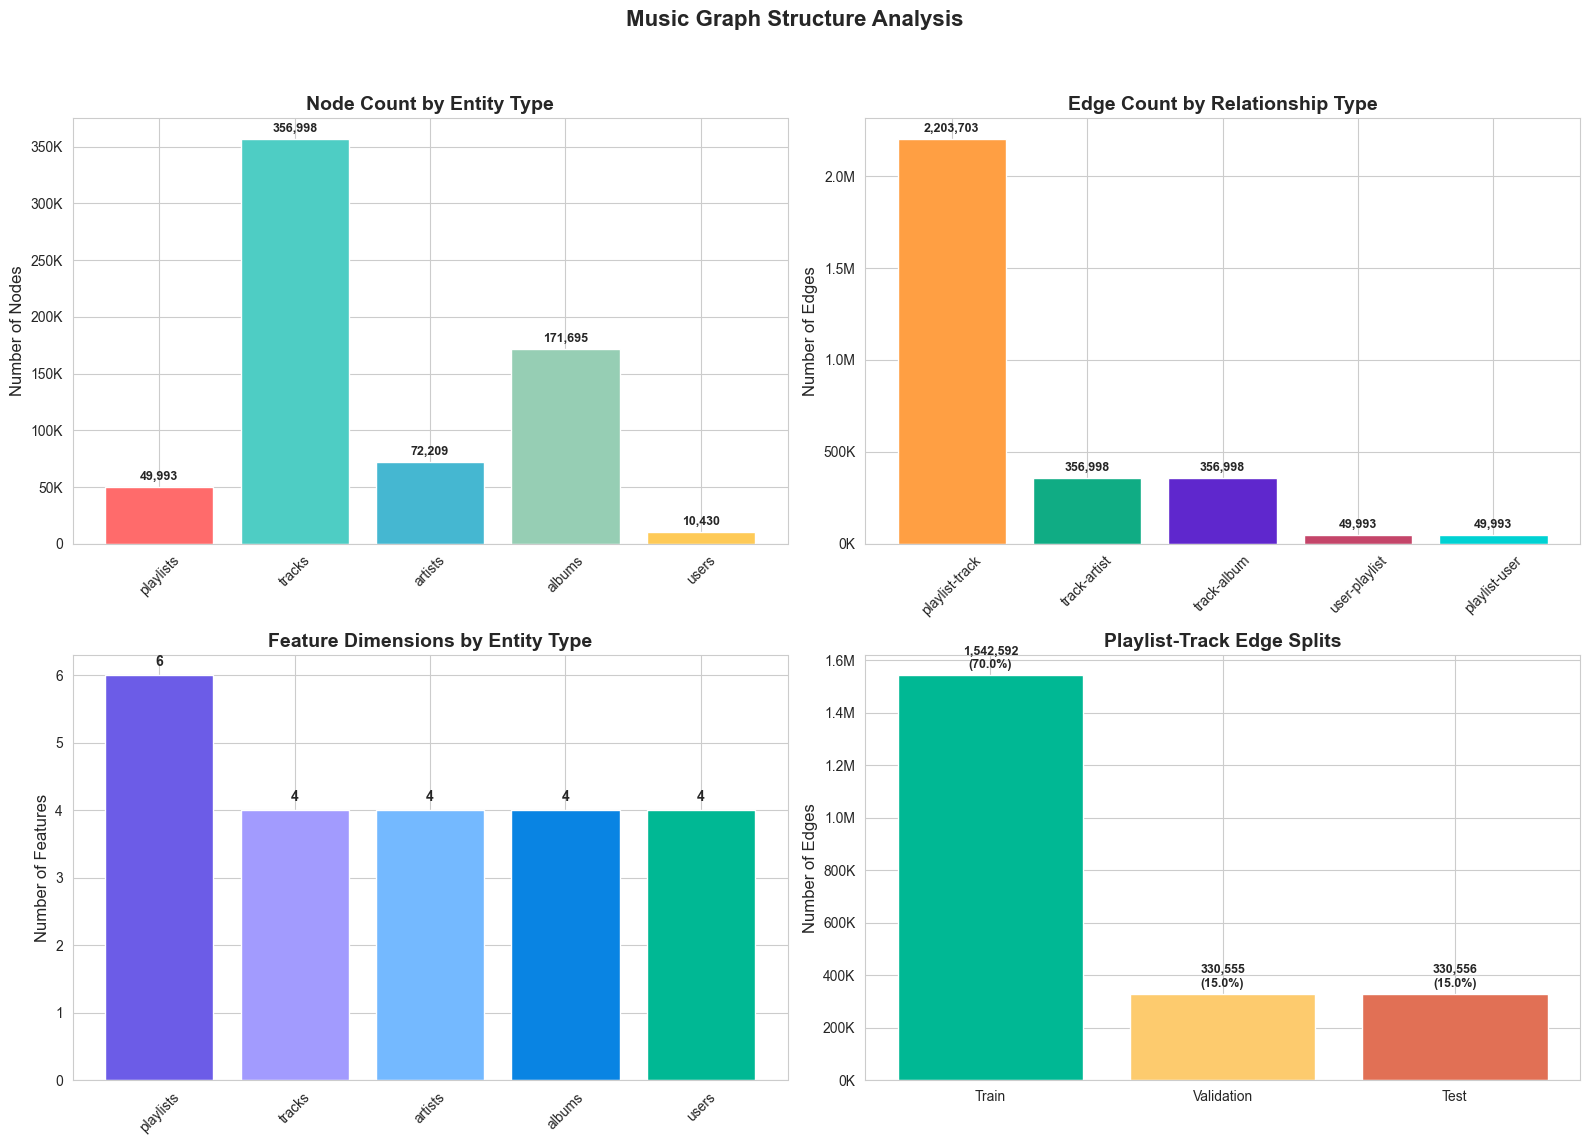

✅ Visualizations created successfully

📊 VISUALIZATION SUMMARY:
   🎵 Largest entity type: tracks (356,998 nodes)
   🔗 Most connected edge type: playlist_track (2,203,703 edges)
   🎨 Highest feature dimension: 6 features

✅ GRAPH VERIFICATION

🔍 Full Graph:
   • Node types: 5
   • Edge types: 5
   • playlist features: torch.Size([49993, 6]), NaN count: 0
   • track features: torch.Size([356998, 4]), NaN count: 0
   • artist features: torch.Size([72209, 4]), NaN count: 0
   • album features: torch.Size([171695, 4]), NaN count: 0
   • user features: torch.Size([10430, 4]), NaN count: 0
   ✅ playlist--contains-->track: All indices valid
   ✅ track--performed_by-->artist: All indices valid
   ✅ track--belongs_to-->album: All indices valid
   ✅ user--created-->playlist: All indices valid
   ✅ playlist--created_by-->user: All indices valid
   • Total edges: 3,017,685

🔍 Train Graph:
   • Node types: 5
   • Edge types: 5
   • playlist features: torch.Size([49993, 6]), NaN count: 0
   • track f

In [16]:
# Initialize the graph constructor
data_directory = "../data/processed/gnn_ready"
graph_constructor = MusicGraphConstructor(data_directory)

# Execute the complete graph construction pipeline
print("🚀 STARTING COMPLETE GRAPH CONSTRUCTION PIPELINE")
print("=" * 60)

# Step 1: Load preprocessed data
graph_constructor.load_preprocessed_data()

# Step 2: Create node mappings
global_mappings = graph_constructor.create_node_mappings()

# Step 3: Create the complete graph
graph_constructor.create_full_graph()

# Step 4: Create train/validation/test graphs
graph_constructor.create_train_val_test_graphs()

# Step 5: Analyze graph structure
graph_constructor.analyze_graph_structure()

# Step 6: Create visualizations
graph_constructor.visualize_graph_statistics()

# Step 7: Verify all graphs
graph_constructor.verify_graphs()

# Step 8: Save graphs to disk
output_directory = "../data/processed/graphs"
graph_constructor.save_graphs(output_directory)

print("🎉 GRAPH CONSTRUCTION PIPELINE COMPLETED SUCCESSFULLY!")
print("=" * 60)
print("✅ All graph objects are ready for GNN training")
print("📁 Graphs saved to:", output_directory)
print("🚀 Next step: Implement baseline models and GNN architecture")
print()

# Quick access to constructed graphs - FIXED ASSIGNMENT
full_graph = graph_constructor.full_graph
train_graph = graph_constructor.train_graph
val_graph = graph_constructor.val_graph
test_graph = graph_constructor.test_graph

print("📊 QUICK GRAPH ACCESS:")
print(f"   • full_graph: Complete heterogeneous graph ({len(full_graph.node_types)} node types)")
print(f"   • train_graph: Training graph (70% playlist-track edges)")
print(f"   • val_graph: Validation graph (15% playlist-track edges)")
print(f"   • test_graph: Test graph (15% playlist-track edges)")
print()

# Verify the variables are properly assigned
print("🔍 VARIABLE VERIFICATION:")
print(f"   • full_graph type: {type(full_graph)}")
print(f"   • train_graph type: {type(train_graph)}")
print(f"   • Graph has {len(full_graph.node_types)} node types: {list(full_graph.node_types)}")
print(f"   • Graph has {len(full_graph.edge_types)} edge types")
print()

print("🔍 GRAPH DATA ACCESS EXAMPLES:")
print("=" * 40)

# Node features
print("📋 Node Features Access:")
for node_type in full_graph.node_types:
    if hasattr(full_graph[node_type], 'x'):
        features = full_graph[node_type].x
        print(f"   • {node_type}: {features.shape} - full_graph['{node_type}'].x")

print()

# Edge indices
print("🔗 Edge Indices Access:")
for edge_type in full_graph.edge_types:
    edge_index = full_graph[edge_type].edge_index
    src_type, relation, dst_type = edge_type
    print(f"   • {src_type}--{relation}-->{dst_type}: {edge_index.shape} - full_graph[{edge_type}].edge_index")

print()

# Example usage for model training
print("🎯 EXAMPLE: PREPARING DATA FOR MODEL")
print("=" * 40)
print(f"""
# How to use these graphs in your GNN model:

# 1. Load a specific graph
train_graph = torch.load('../data/processed/graphs/train_graph.pt')

# 2. Access node features (use actual node type names from your graph)
playlist_features = train_graph['playlist'].x      # Shape: [49993, 6]
track_features = train_graph['track'].x            # Shape: [356998, 4]
user_features = train_graph['user'].x              # Shape: [10430, 4]
artist_features = train_graph['artist'].x          # Shape: [72209, 4]
album_features = train_graph['album'].x            # Shape: [171695, 4]

# 3. Access edge connections
playlist_track_edges = train_graph['playlist', 'contains', 'track'].edge_index
# Shape: [2, num_edges] where first row is playlist IDs, second row is track IDs

# 4. Create training pairs for link prediction
positive_edges = train_graph['playlist', 'contains', 'track'].edge_index.T
# Shape: [num_edges, 2] - each row is [playlist_id, track_id]

# 5. Use in your GNN forward pass
# scores = model(train_graph, positive_edges)
""")

print("🎵 Heterogeneous music graph is now ready for GNN training!")
print("🚀 Next: Implement baseline models and then your GNN architecture!")